**F23 MATH 596 Final Project Code**

# Imports

In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io
import pywt
from sklearn import preprocessing

import credit_card_fraud as ccf

%matplotlib inline

# Grabbing Data

In [2]:
# Working on setting up Kaggle.com API to grab data so that there is no need to read csv file or upload csv onto Github
# This has proved to be difficult and the actual efficiency of this approach is to be determined
#For now, here is the original method I used requiring users to download the dataset themselves
df = pd.read_csv(".../F23-MATH596-FinalProjectCode/creditcard_2023.csv") # Location of csv different from PC to PC
df.drop(['id'], axis=1, inplace = True)
target=['Class']

In [3]:
feature_names = ccf.features(df, target)

# Data Analysis - Histogram of Amount

Why we drop Amount


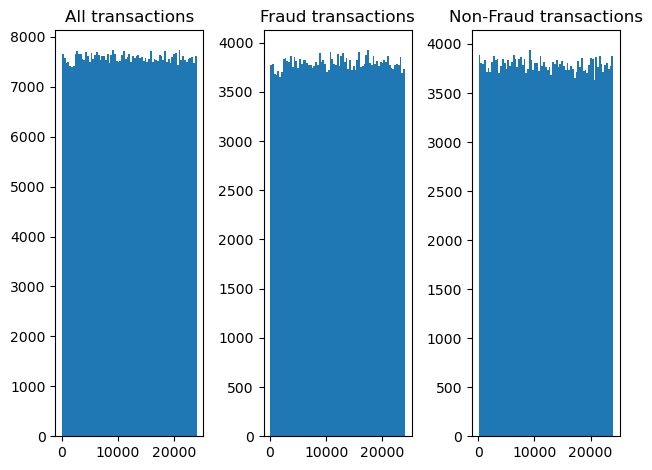

In [4]:
ccf.fraud_hist(df, 75)

Clearly there is not decernable information we can learn from Amount, so we can drop Amount

In [6]:
df.drop(['Amount'], axis=1, inplace = True)

# Data Analysis - PCA

Why we drop V8, V13, V15, V20 V21, V22, V23, V24, V25, V26, V27, and V28

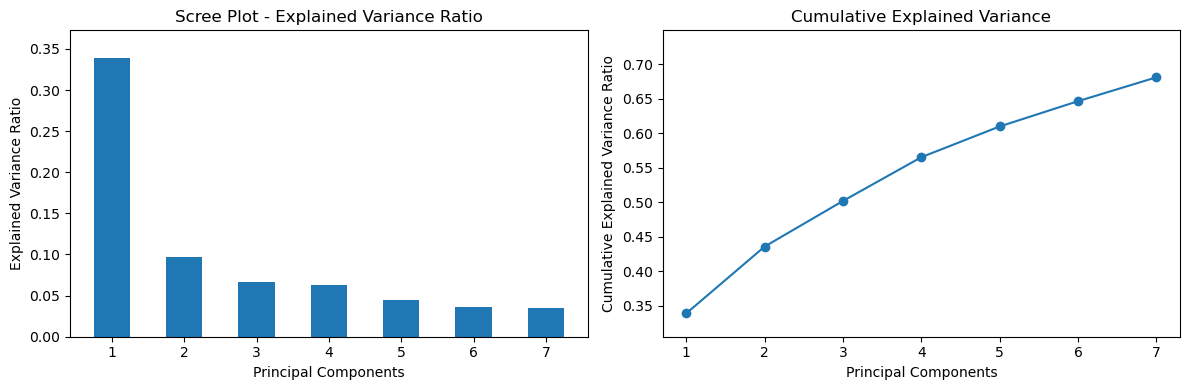

[0.33872158 0.09688719 0.06618998 0.06346626 0.04459286 0.03666183
 0.03459292 0.03441276 0.02999273 0.02833916 0.02597564 0.02131675
 0.01909455 0.0173951  0.01708433 0.0141626  0.01343088 0.01233759
 0.01219622 0.009879   0.00972481 0.0085329  0.00815503 0.00744716
 0.00675692 0.00656616 0.00629288 0.00601301 0.00378119]


In [5]:
ccf.scree_plt(df, feature_names)

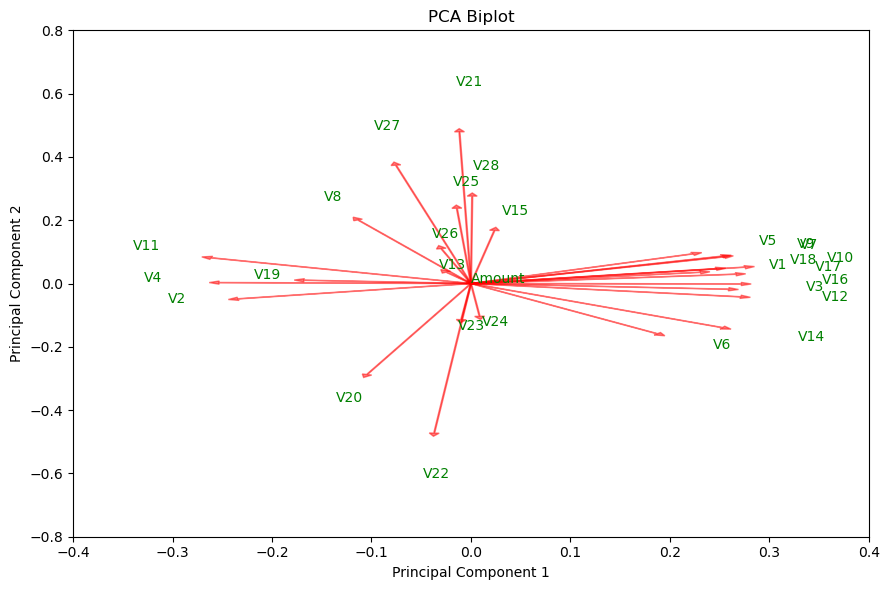

In [6]:
ccf.pca_biplot(df, feature_names)

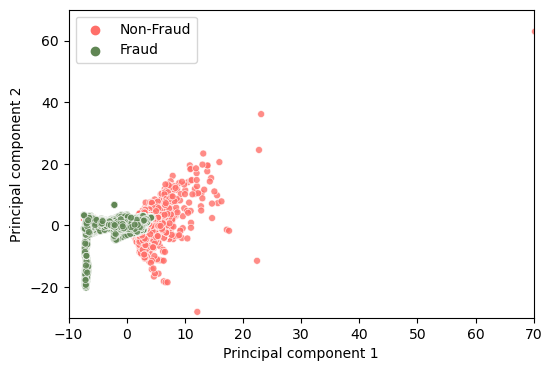

In [7]:
ccf.pca_scatter(df, feature_names)

In [9]:
V = df[['V1','V2','V3','V4','V5','V6','V7','V9','V10','V11','V12','V14','V16','V17','V18','V19']]
y = df['Class']

# Modeling
How we constructed our model starting with linear Regression to our final LASSO model

In [10]:
ccf.fraud_model(V, y)

Mean linear regression model accuracy: 94.7 %



In [11]:
ccf.max_lambda(V, y)

Accuracy: 93.0 %
Lamda: 0.4


In [12]:
ccf.fraud_model(V, y, 20, True, 0, 0.25)
print("------------------------------------------------")
ccf.fraud_model(V, y, 20, True, 0.1, 0.3)
ccf.fraud_model(V, y, 20, True, 0.2, 0.4)
ccf.fraud_model(V, y, 20, True, 0.3, 0.45)
ccf.fraud_model(V, y, 20, True, 0.4, 0.5)
print("------------------------------------------------")
ccf.fraud_model(V, y, 20, True, 0.5, 0.25, True)
ccf.fraud_model(V, y, 20, True, 1, 0.25, True)
ccf.fraud_model(V, y, 20, True, 1.5, 0.25, True)
ccf.fraud_model(V, y, 20, True, 2, 0.25, True)

Mean linear Regression Model accuracy: 92.0 %
True positive rate: 97.5 %
True negative rate: 86.4 %
False positive rate: 13.6 %
False negative rate: 2.5 %

------------------------------------------------
Mean LASSO Regression Model accuracy: 89.3 %
True positive rate: 97.9 %
True negative rate: 80.7 %
False positive rate: 19.3 %
False negative rate: 2.1 %

Mean LASSO Regression Model accuracy: 92.1 %
True positive rate: 95.9 %
True negative rate: 88.3 %
False positive rate: 11.7 %
False negative rate: 4.1 %

Mean LASSO Regression Model accuracy: 87.7 %
True positive rate: 95.9 %
True negative rate: 79.4 %
False positive rate: 20.6 %
False negative rate: 4.1 %

Mean LASSO Regression Model accuracy: 92.9 %
True positive rate: 88.5 %
True negative rate: 97.3 %
False positive rate: 2.7 %
False negative rate: 11.5 %

------------------------------------------------
Mean ridge Regression Model accuracy: 91.9 %
True positive rate: 97.5 %
True negative rate: 86.4 %
False positive rate: 13.6 %